In [130]:
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib import rc
rc('font',**{'family':'Times New Roman', 'size': 18})
rc('text', usetex=True)
rc('figure', figsize = (10,5))

import cv2
import csv
from collections import OrderedDict 

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skimage.feature import hog
from skimage import data, color, exposure

In [2]:
"""
a = cv2.imread("train/train/img-0.jpeg", 0)
a.shape
plt.imshow(a, cmap='gray')

#for i in range (img.shape[0]): 
            #for j in range (img.shape[1]):
                #curr.append(img[i][j])
""";

In [3]:
label_dict = {'normal': 0, 'covid': 1, 'viral':2, 'bacterial':3}
label_to_words = {0: 'normal', 1: 'covid', 2: 'viral', 3: 'bacterial'}

In [4]:
def read_dir(dir_name):
    #return a dictionary of raw array representations of the images, indexed by image number
    rawdata = {}
    for file in os.listdir(dir_name):
        filename = dir_name + '/' + os.fsdecode(file)
        img = cv2.imread(filename, 0) #0 indicates 1 channel - grayscale
        
        name = file
        name = name.replace('img-', '')
        name = name.replace('.jpeg', '')
        #curr number
        no = int(name)
        rawdata[no] = img

    return OrderedDict(sorted(rawdata.items())) #ordered data

In [5]:
def read_labels(filename):
    raw_csv = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for rowdata in reader:
            if any(x.strip() for x in rowdata):
                raw_csv.append(rowdata)
    
    labels = {}
    for i in range(len(raw_csv)):
        curr = raw_csv[i]
        ind = int(curr[0])
        labels[ind] = label_dict[curr[2]]
    
    return labels

In [6]:
def standardize(data, height, width):
    #takes a dictionary of arrays, returns a dictionary of arrays, all with the same size
    dim = (height, width)
    new_data = {}
    for i in range(len(data)):
        img = data[i]
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        new_data[i] = resized
    
    return new_data

In [7]:
def flatten(data):
    flattened_data = {}
    for i in range(len(data)):
        img = data[i]
        height = img.shape[0]
        width = img.shape[1]
        
        curr = np.zeros(height*width)
        for h in range(height):
            for w in range(width):
                curr[h*width + w] = img[h][w]
        
        flattened_data[i] = curr
    
    return flattened_data

In [8]:
def split(data, perc):
    #split training data into train and test, for holdout validation
    train_n = int(perc * len(data))
    train = {}
    test = {}
    for i in range(len(data)):
        if i <= train_n:
            train[i] = data[i]
        else:
            test[i] = data[i]
    
    return train, test

In [9]:
def makesubmission(no, results):
    word_results = {}
    for i in range(len(results)):
        word_results[i] = label_to_words[results[i]]
    with open('submission {x}.csv'.format(x = no), mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=',')

        writer.writerow(['Id', 'label'])
        for i in range(len(results)):
            writer.writerow([i, word_results[i]])

## Rudimentary standardization of data - simply flatten all images to lists of pixel values of the same size

In [10]:
train_dir = 'train/train'
raw_traindata = read_dir(train_dir)

In [11]:
traindata = standardize(raw_traindata, 200, 200) #traindata is dict of 2d np array of same size, corresponding to images
flat_traindata = flatten(traindata) #flat_traindata is dict of 1d lists

In [12]:
filename = 'train.csv'
train_labels = read_labels(filename)

In [13]:
test_dir = 'test/test'
raw_testdata = read_dir(test_dir)

In [14]:
testdata = standardize(raw_testdata, 200, 200)
flat_testdata = flatten(testdata)

### Try perceptron without any kernelization

In [15]:
def add_bias(data):
    n = len(data)
    bias = np.ones(1)
    newdata = {}
    for i in range(n):
        newdata[i] = np.hstack((data[i], bias))
    return newdata

In [16]:
def updatew(w, x, y):
    #for a single w vector. y is +1 or -1 for this specific label
    corrected_pred = y*np.dot(w, x)
    if corrected_pred <= 0:
        return w + y*x
    else:
        return w

In [17]:
def updatew_corona(w, x, y): #penalize false negatives on corona more
    #add more weight to corona vector to maximize positive corona classification
    pred = np.dot(w, x)
    corrected_pred = y*pred
    if pred <= 0: #if predicts -ve on corona
        if (y == 1): #if actually has corona
            return w + 4*x
    
    if corrected_pred <= 0:
        return w + y*x
    else:
        return w

In [18]:
def predict(ws, x):
    #ws is list of 4 weights, and x is data point
    amounts = np.zeros(4)
    for i in range(len(ws)):
        amounts[i] = np.dot(ws[i], x)
    return np.argmax(amounts)

In [19]:
def onevall_label(labels, label):
    new_labels = {}
    for i in labels:
        if labels[i] != label:
            new_labels[i] = -1
        else:
            new_labels[i] = 1
    
    return new_labels
        

In [20]:
def uw_perceptron(data, labels, iterations):
    ws = []
    for res in range(4):
        w = np.zeros(len(data[0]))
        new_labels = onevall_label(labels, res)
        for i in range(iterations):
            index = i % (len(data)-1) + 1
            w = updatew(w, data[index], new_labels[index])
        ws.append(w)
    
    return ws

In [21]:
def w_perceptron(data, labels, iterations):
    ws = []
    for res in range(4):
        w = np.zeros(len(data[0]))
        new_labels = onevall_label(labels, res)
        for i in range(iterations):
            index = i % (len(data)-1) + 1
            if res==1:
                #corona
                w = updatew_corona(w, data[index], new_labels[index])
            else:
                w = updatew(w, data[index], new_labels[index])
        ws.append(w)
    
    return ws

In [22]:
def predictall(ws, data):
    results = {}
    for key in data:
        results[key] = predict(ws, data[key])
    return results

In [23]:
def uw_accuracy(results, labels):
    #unweighted accuracy
    sum = 0
    for key in results:
        if(results[key] == labels[key]):
            sum += 1
    
    return sum / len(results)

In [24]:
def w_accuracy(results, labels):
    #weighted accuracy, with preferential treatment to +ve corona identification
    corona_count = 0
    noncorona_count = 0
    corona_sum = 0
    noncorona_sum = 0
    
    for i in results: #i is key
        if(labels[i] == 1):
            corona_count += 1
            if (results[i] == 1):
                corona_sum += 1
        else:
            noncorona_count += 1
            if(results[i] == labels[i]):
                noncorona_sum += 1
    
    return (noncorona_sum + 5*corona_sum)/(noncorona_count + 5*corona_count)

In [25]:
perc_traindata = add_bias(flat_traindata)

### Train unweighted perceptron

In [369]:
train70, test30 = split(perc_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

In [524]:
weights = uw_perceptron(train70, trainlabels70, 3500)
res = predictall(weights, test30)
#Problem1: Very dependent on no. of iterations
#Problem2: Very few labeled as viral

In [525]:
uw_accuracy(res, testlabels30)

0.6301775147928994

In [526]:
w_accuracy(res, tmp_testlabels)

0.6748878923766816

In [527]:
tmp_train, tmp_test = split(perc_traindata, 0.5)
tmp_trainlabels, tmp_testlabels = split(train_labels, 0.5)

weights = uw_perceptron(tmp_train, tmp_trainlabels, 2500)
res = predictall(weights, tmp_test)

In [528]:
uw_accuracy(res, tmp_testlabels)

0.6039076376554174

In [540]:
tmp_train, tmp_test = split(perc_traindata, 0.9)
tmp_trainlabels, tmp_testlabels = split(train_labels, 0.9)

weights = uw_perceptron(tmp_train, tmp_trainlabels, 5000)
res = predictall(weights, tmp_test)

In [541]:
uw_accuracy(res, tmp_testlabels)

0.6517857142857143

In [542]:
w_accuracy(res, tmp_testlabels)

0.7171052631578947

### UW Perceptron Submission

In [545]:
perc_testdata = add_bias(flat_testdata)

In [546]:
#perceptron trial, not weighted for corona
weights = uw_perceptron(perc_traindata, train_labels, 5000)
subm4 = predictall(weights, perc_testdata)

In [547]:
makesubmission(4, subm4)

### Train weighted Perceptron

In [599]:
train70, test30 = split(perc_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

weights = w_perceptron(train70, trainlabels70, 3400)
res = predictall(weights, test30)

In [600]:
uw_accuracy(res, testlabels30)

0.6538461538461539

In [601]:
w_accuracy(res, testlabels30)

0.7017937219730942

In [618]:
train50, test50 = split(perc_traindata, 0.5)
trainlabels50, testlabels50 = split(train_labels, 0.5)

weights = w_perceptron(train50, trainlabels50, 2500)
res = predictall(weights, test50)

In [619]:
uw_accuracy(res, testlabels50)

0.6145648312611013

In [620]:
w_accuracy(res, testlabels50)

0.615595075239398

In [646]:
train90, test10 = split(perc_traindata, 0.9)
trainlabels90, testlabels10 = split(train_labels, 0.9)

weights = w_perceptron(train90, trainlabels90, 4000)
res = predictall(weights, test10)
##For this split of the data, it seems that it's almost stable above num_iterations >= 4000

In [647]:
uw_accuracy(res, testlabels10)

0.6517857142857143

In [648]:
w_accuracy(res, testlabels10)

0.6907894736842105

In [607]:
##The fact that the weighted performed almost as bad as the unweighted -> the data is really poorly represented for linear
##classification

### Weighted Perceptron Submission

In [654]:
perc_testdata = add_bias(flat_testdata)

In [655]:
weights = w_perceptron(perc_traindata, train_labels, 5000)
subm5 = predictall(weights, perc_testdata)

In [657]:
makesubmission(5, subm5)

### SVM

In [658]:
X_train, X_test, y_train, y_test = train_test_split(flat_traindata, train_labels, random_state = 0, test_size = 0.3) 
svclassifier = SVC(kernel='linear')
model = svclassifier.fit(X_train, y_train) 

In [659]:
svm_predictions = model.predict(X_test)

In [660]:
model.score(X_test, y_test)

0.5958702064896755

In [ ]:
confusion_matrix(y_test, svm_predictions)

In [683]:
train70, test30 = split(flat_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

list_train70 = list(train70.values())
list_test30 = list(test30.values())
list_trainlabels70 = list(trainlabels70.values())
list_testlabels30 = list(testlabels30.values())

svclassifier = SVC(kernel='linear')
model = svclassifier.fit(list_train70, list_trainlabels70) 

In [684]:
svm_predictions = model.predict(list_test30) 

In [685]:
uw_accuracy(svm_predictions, list_testlabels30)

1.0

In [680]:
model.score(list_test30, list_testlabels30)

0.6005917159763313

### SVM submission

In [687]:
list_train = list(flat_traindata.values())
list_trainlabels = list(train_labels.values())

svclassifier = SVC(kernel='linear')
model = svclassifier.fit(list_train, list_trainlabels) 

In [688]:
list_test = list(flat_testdata.values())

In [689]:
subm6 = model.predict(list_test) 

In [691]:
makesubmission(6, subm6)

### Kernelized SVM

In [30]:
X_train, X_test, y_train, y_test = train_test_split(flat_traindata, train_labels, random_state = 0, test_size = 0.3)

degs = [3, 6, 10, 15, 20, 25, 30]
models = []
for deg in degs:
    svclassifier = SVC(kernel='poly', degree=deg, gamma='scale')
    curr_model = svclassifier.fit(X_train, y_train)
    models.append(curr_model)
    print(deg)

3
6
10
15
20
25
30


In [31]:
accuracies = []
cms = []
for i in range(len(degs)):
    curr_predic = models[i].predict(X_test)
    curr_acc = models[i].score(X_test, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accuracies.append(curr_acc)
    cms.append(curr_cm)
    #print(i)

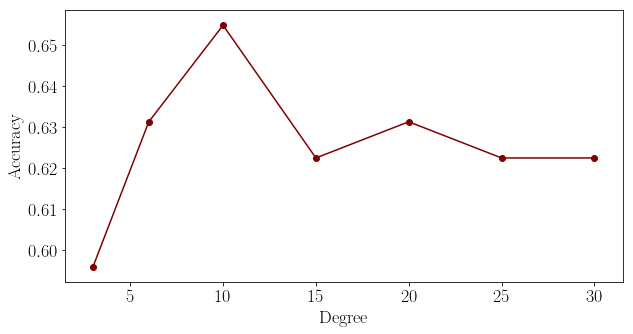

In [32]:
plt.plot(degs, accuracies, 'maroon')
plt.scatter(degs, accuracies, color='maroon')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.savefig('Ker_SVM', dpi=200)

In [705]:
cms

[array([[84,  3, 16,  7],
        [ 2, 17,  9,  1],
        [13,  0, 49, 46],
        [ 5,  1, 34, 52]], dtype=int64), array([[89,  3, 11,  7],
        [ 2, 18,  8,  1],
        [12,  0, 51, 45],
        [ 7,  1, 28, 56]], dtype=int64), array([[93,  2,  7,  8],
        [ 3, 19,  5,  2],
        [15,  0, 49, 44],
        [ 8,  1, 22, 61]], dtype=int64), array([[93,  2,  8,  7],
        [ 6, 14,  5,  4],
        [17,  1, 44, 46],
        [ 6,  1, 25, 60]], dtype=int64), array([[91,  2,  8,  9],
        [ 7, 12,  6,  4],
        [15,  2, 48, 43],
        [ 4,  0, 25, 63]], dtype=int64)]

### Kernelized SVM submission

In [929]:
list_train = list(flat_traindata.values())
list_trainlabels = list(train_labels.values())

svclassifier = SVC(kernel='poly', degree=10, gamma='scale')
model = svclassifier.fit(list_train, list_trainlabels) 

In [930]:
list_test = list(flat_testdata.values())

In [931]:
subm7 = model.predict(list_test) 

In [932]:
makesubmission(7, subm7)

## Now use dimensionality reduction w SVM

In [713]:
X_train, X_test, y_train, y_test = train_test_split(flat_traindata, train_labels, random_state = 0, test_size = 0.3)

In [724]:
#first normalize
sc = StandardScaler()
normal_train70 = sc.fit_transform(X_train)
normal_test30 = sc.transform(X_test)

In [728]:
pca = PCA()
pca_train70 = pca.fit_transform(normal_train70)
pca_test30 = pca.transform(normal_test30)

In [732]:
degs = [1, 2, 3, 4, 5]
models = []
for deg in degs:
    svclassifier = SVC(kernel='poly', degree=deg, gamma='scale')
    curr_model = svclassifier.fit(pca_train70, y_train)
    models.append(curr_model)
    #print(deg)

In [733]:
accuracies = []
cms = []
for i in range(len(degs)):
    curr_predic = models[i].predict(pca_test30)
    curr_acc = models[i].score(pca_test30, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accuracies.append(curr_acc)
    cms.append(curr_cm)

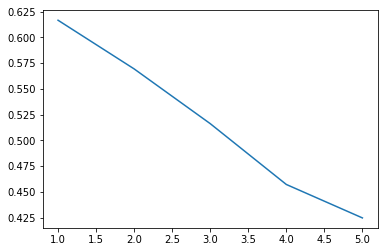

In [737]:
plt.plot(degs, accuracies)

In [735]:
cms

[array([[90,  2, 11,  7],
        [ 4, 18,  3,  4],
        [15,  0, 43, 50],
        [ 9,  0, 25, 58]], dtype=int64), array([[79,  0,  6, 25],
        [ 5, 15,  4,  5],
        [ 6,  0, 26, 76],
        [ 2,  0, 17, 73]], dtype=int64), array([[67,  1,  1, 41],
        [ 4, 12,  5,  8],
        [ 6,  0, 17, 85],
        [ 3,  0, 10, 79]], dtype=int64), array([[44,  2,  2, 62],
        [ 2,  9,  5, 13],
        [ 3,  0, 13, 92],
        [ 0,  0,  3, 89]], dtype=int64), array([[33,  1,  1, 75],
        [ 1,  8,  3, 17],
        [ 2,  0, 12, 94],
        [ 1,  0,  0, 91]], dtype=int64)]

## Use dim-reduction with perceptron, w/out kernel

In [742]:
flat_train70, flat_test30 = split(flat_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

In [744]:
sc = StandardScaler()
normal_train70 = sc.fit_transform(list(flat_train70.values()))
normal_test30 = sc.transform(list(flat_test30.values()))

In [745]:
pca = PCA()
pca_train70 = pca.fit_transform(normal_train70)
pca_test30 = pca.transform(normal_test30)

In [748]:
perc_train70 = add_bias(pca_train70)
perc_test30 = add_bias(pca_test30)

In [835]:
weights = uw_perceptron(perc_train70, trainlabels70, 2000)
res = predictall(weights, perc_test30)

In [836]:
dict_res = {}
i = 0
for key in testlabels30:
    dict_res[key] = res[i]
    i+=1

In [837]:
uw_accuracy(dict_res, testlabels30)

0.5562130177514792

In [842]:
flat_train90, flat_test10 = split(flat_traindata, 0.9)
trainlabels90, testlabels10 = split(train_labels, 0.9)

In [843]:
sc = StandardScaler()
normal_train90 = sc.fit_transform(list(flat_train90.values()))
normal_test10 = sc.transform(list(flat_test10.values()))

In [844]:
pca = PCA()
pca_train90 = pca.fit_transform(normal_train90)
pca_test10 = pca.transform(normal_test10)

In [845]:
perc_train90 = add_bias(pca_train90)
perc_test10 = add_bias(pca_test10)

In [921]:
weights = uw_perceptron(perc_train90, trainlabels90, 5500)
res = predictall(weights, perc_test10)

In [922]:
dict_res = {}
i = 0
for key in testlabels10:
    dict_res[key] = res[i]
    i+=1

In [923]:
uw_accuracy(dict_res, testlabels10)

0.6160714285714286

### Submit dim-reduc perceptron

In [840]:
sc = StandardScaler()
normal_train = sc.fit_transform(list(flat_traindata.values()))
normal_test = sc.transform(list(flat_testdata.values()))

In [841]:
pca = PCA()
pca_train = pca.fit_transform(normal_train)
pca_test = pca.transform(normal_test)

In [924]:
perc_train = add_bias(pca_train)
perc_test = add_bias(pca_test)

In [933]:
weights = uw_perceptron(perc_train, train_labels, 5500)
subm8 = predictall(weights, perc_test)

In [934]:
makesubmission(8, subm8)

### Try kernelized Perceptron

In [33]:
def kernel_dots(x, data_arr, p):
    return (1+np.dot(data_arr, x))**p

In [34]:
def kernel_perceptron(data, labels, p, iterations):
    n = len(data)
    d = len(data[0])
    
    data_arr = np.zeros((n,d))
    for i in range(n):
        data_arr[i] = data[i]
        
    alphas = np.zeros((4,n))
    for res in range(4):
        curr_labels = np.array(list(onevall_label(labels, res).values()))
        alpha = np.zeros(n)
        for i in range(iterations):
            index = i % (n-1) + 1
            alpha = kernel_updatealpha(data_arr, curr_labels, alpha, index, p)
        
        alphas[res] = alpha
    
    return alphas
"""
    alphas = np.zeros((4, n))
    all_labels = np.zeros((4, n))
    
    for res in range(4):
        new_labels = onevall_label(labels, res)
        all_labels[res] = np.array(list(new_labels.values()))
    
    for i in range(iterations):
        index = i % (n-1) + 1
        alphas = kernel_updatealphas(data_arr, all_labels, alphas, index, p)
    
    return alphas
""";

In [35]:
def kernel_updatealpha(data_arr, labels, alpha, index, p):
    x = data_arr[index]
    y = labels[index]
    corrected_pred = y*kernel_predict1(data_arr, labels, alpha, x, p)
        
    if corrected_pred <= 0:
        alpha[index] += 1
        
    return alpha
    
"""
    for res in range(4):
        y = ys[res]
        corrected_pred = y*kernel_predict1(data_arr, labels[res], alphas[res], x, p)
        
        if corrected_pred <= 0:
            alphas[res][index] += 1
    
    return alphas
""";

In [36]:
def kernel_predict1(data_arr, label, alpha, x, p):
    dots = kernel_dots(x, data_arr, p)
    return np.dot(dots, alpha*label)

In [37]:
def kernel_predict(data_arr, all_labels, alphas, x, p):
    amounts = np.zeros(4)
    for res in range(4):
        alpha = alphas[res]
        label = all_labels[res]
        dots = kernel_dots(x, data_arr, p)
        amounts[res] = np.dot(dots, alpha*label)
    
    return np.argmax(amounts)

In [38]:
def kernel_predictall(training, train_labels, alphas, test, p):
    data_arr = np.array(list(training.values()))
    all_labels = np.zeros((4, len(data_arr)))
    for res in range(4):
        new_labels = onevall_label(train_labels, res)
        all_labels[res] = np.array(list(new_labels.values()))
    
    results = {}
    for key in test:
        results[key] = kernel_predict(data_arr, all_labels, alphas, test[key], p)
    return results

In [39]:
perc_traindata = add_bias(flat_traindata)

In [40]:
train70, test30 = split(perc_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)
#Problem1: Very dependent on no. of iterations
#Problem2: Very few labeled as viral

In [ ]:
alphas = kernel_perceptron(train70, trainlabels70, 2, 3000)

In [102]:
res = kernel_predictall(train70, trainlabels70, alphas, test30, 2)

In [103]:
uw_accuracy(res, testlabels30)

0.6301775147928994

In [117]:
train70, test30 = split(perc_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

alphas = kernel_perceptron(train70, trainlabels70, 4, 2500)
#Problem1: Very dependent on no. of iterations
#Problem2: Very few labeled as viral

In [118]:
res = kernel_predictall(train70, trainlabels70, alphas, test30, 4)

In [119]:
uw_accuracy(res, testlabels30)

0.6301775147928994

In [42]:
ps = [3, 6, 10, 15]
iters =  [2000, 2500, 3000, 3500]

accs = np.zeros((len(ps), len(iters)))
all_alphas = {}

for i in range(len(ps)):
    for j in range(len(iters)):
        p = ps[i]
        it = iters[j]
        curr_alphas = kernel_perceptron(train70, trainlabels70, p, it)
        all_alphas[tuple((p, it))] = curr_alphas
        
        curr_res = kernel_predictall(train70, trainlabels70, curr_alphas, test30, p)
        curr_acc = uw_accuracy(curr_res, testlabels30)
        accs[i][j] = curr_acc
        
        print(p, it)
        print(curr_acc)

3 2000
0.606508875739645
3 2500
0.6449704142011834
3 3000
0.6775147928994083
3 3500
0.6390532544378699
6 2000
0.6597633136094675
6 2500
0.6183431952662722
6 3000
0.6568047337278107
6 3500
0.591715976331361
10 2000
0.6597633136094675
10 2500
0.6331360946745562
10 3000
0.6449704142011834
10 3500
0.6420118343195266
15 2000
0.4260355029585799
15 2500
0.4556213017751479
15 3000
0.6479289940828402
15 3500
0.6449704142011834


In [44]:
best_accs = []
for i in range(len(ps)):
    best_accs.append(np.max(accs[i]))

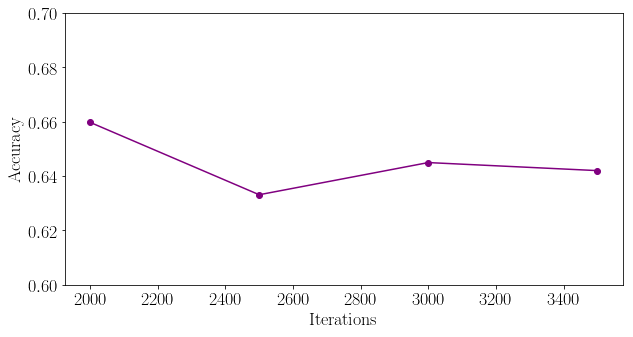

In [50]:
plt.scatter(iters, accs[2], color='purple')
plt.plot(iters, accs[2], color='purple')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.6, 0.7)
plt.savefig('Ker_Perc', dpi=200)

In [135]:
alphas = kernel_perceptron(train70, trainlabels70, 10, 2100)
res = kernel_predictall(train70, trainlabels70, alphas, test30, 10)
uw_accuracy(res, testlabels30)
##p=10, n=2100 gives 0.67 acc

0.6331360946745562

In [137]:
train90, test10 = split(perc_traindata, 0.9)
trainlabels90, testlabels10 = split(train_labels, 0.9)
#alphas = kernel_perceptron(train90, trainlabels90, 4, 5000)
#Problem1: Very dependent on no. of iterations
#Problem2: Very few labeled as viral

In [138]:
ps = [6, 8, 10]
iters =  [2000, 2500, 3000, 3500]

accs90 = np.zeros((len(ps), len(iters)))
all_alphas90 = {}

for i in range(len(ps)):
    for j in range(len(iters)):
        p = ps[i]
        it = iters[j]
        curr_alphas = kernel_perceptron(train90, trainlabels90, p, it)
        all_alphas90[tuple((p, it))] = curr_alphas
        
        curr_res = kernel_predictall(train90, trainlabels90, curr_alphas, test10, p)
        curr_acc = uw_accuracy(curr_res, testlabels10)
        accs90[i][j] = curr_acc
        
        print(p, it)
        print(curr_acc)
        print()

6 2000
0.7589285714285714

6 2500
0.6517857142857143

6 3000
0.5357142857142857

6 3500
0.5892857142857143

8 2000
0.5446428571428571

8 2500
0.6339285714285714

8 3000
0.5178571428571429

8 3500
0.4732142857142857

10 2000
0.5982142857142857

10 2500
0.5357142857142857

10 3000
0.5446428571428571

10 3500
0.6160714285714286



In [156]:
alphas = kernel_perceptron(train90, trainlabels90, 6, 2000)
res = kernel_predictall(train90, trainlabels90, alphas, test10, 6)
uw_accuracy(res, testlabels10)
#p=6, n=2000
#p=10, n=1000 ->0.65

0.7589285714285714

### Make Submission

In [ ]:
alphas = kernel_perceptron(train90, trainlabels90, 6, 2000)

In [158]:
perc_testdata = add_bias(flat_testdata)

In [159]:
subm9 = kernel_predictall(train90, trainlabels90, alphas, perc_testdata, 6)

In [160]:
makesubmission(9, subm9)

In [162]:
alphas = kernel_perceptron(train70, trainlabels70, 10, 2100)

In [163]:
subm10 = kernel_predictall(train70, trainlabels70, alphas, perc_testdata, 10)

In [164]:
makesubmission(10, subm10)

## Histogram of Oriented Gradients

In [226]:
#fd, hog_image = hog(traindata[4], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)

In [196]:
train_dir = 'train/train'
raw_traindata = read_dir(train_dir)
traindata = standardize(raw_traindata, 200, 200)

In [197]:
test_dir = 'test/test'
raw_testdata = read_dir(test_dir)
testdata = standardize(raw_testdata, 200, 200)

In [51]:
def transf_hog(data, orient, pixsv, pixsh):
    newdata = {}
    imgs = {}
    for i in range(len(data)):
        fd, hog_im = hog(data[i], orientations=orient, pixels_per_cell=(pixsv, pixsh),
                    cells_per_block=(1, 1), visualize=True)
        newdata[i] = fd
        imgs[i] = hog_im
    return newdata, imgs

In [52]:
traindata_hog, train_hogs = transf_hog(traindata, 8, 8, 8)
testdata_hog, test_hogs = transf_hog(testdata, 8, 8, 8)

### Kernelized SVM

In [237]:
X_train, X_test, y_train, y_test = train_test_split(traindata_hog, train_labels, random_state = 0, test_size = 0.3)
svclassifier = SVC(kernel='linear')
model = svclassifier.fit(X_train, y_train)

In [238]:
svm_predictions = model.predict(X_test)

In [239]:
model.score(X_test, y_test)

0.6489675516224189

In [252]:
X_train, X_test, y_train, y_test = train_test_split(traindata_hog, train_labels, random_state = 0, test_size = 0.3)

degs = [1, 3, 6, 8, 10, 12, 16, 18, 20, 25]
models = []
for deg in degs:
    svclassifier = SVC(kernel='poly', degree=deg, gamma='scale')
    curr_model = svclassifier.fit(X_train, y_train)
    models.append(curr_model)
    #print(deg)

In [253]:
accuracies = []
cms = []
for i in range(len(degs)):
    curr_predic = models[i].predict(X_test)
    curr_acc = models[i].score(X_test, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accuracies.append(curr_acc)
    cms.append(curr_cm)
    #print(i)

In [254]:
accuracies

[0.6607669616519174,
 0.6519174041297935,
 0.6430678466076696,
 0.6430678466076696,
 0.640117994100295,
 0.6460176991150443,
 0.6489675516224189,
 0.6342182890855457,
 0.6135693215339233,
 0.5781710914454278]

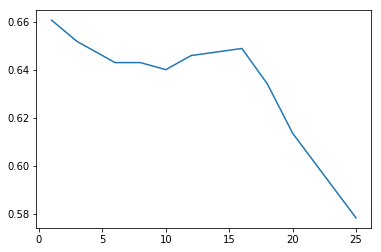

In [255]:
plt.plot(degs, accuracies)

In [256]:
cms

[array([[100,   3,   6,   1],
        [  2,   8,   6,  13],
        [ 15,   0,  56,  37],
        [  6,   0,  26,  60]], dtype=int64),
 array([[99,  2,  7,  2],
        [ 2, 12, 10,  5],
        [13,  0, 62, 33],
        [ 6,  0, 38, 48]], dtype=int64),
 array([[100,   2,   6,   2],
        [  2,  12,   8,   7],
        [ 17,   0,  55,  36],
        [  7,   0,  34,  51]], dtype=int64),
 array([[101,   2,   6,   1],
        [  2,  11,   8,   8],
        [ 18,   0,  53,  37],
        [  8,   0,  31,  53]], dtype=int64),
 array([[101,   2,   6,   1],
        [  2,   9,   7,  11],
        [ 20,   0,  53,  35],
        [  8,   0,  30,  54]], dtype=int64),
 array([[102,   1,   6,   1],
        [  3,  10,   5,  11],
        [ 20,   0,  51,  37],
        [  8,   0,  28,  56]], dtype=int64),
 array([[101,   1,   6,   2],
        [  4,   9,   1,  15],
        [ 20,   0,  53,  35],
        [ 10,   0,  25,  57]], dtype=int64),
 array([[101,   1,   6,   2],
        [  5,   8,   1,  15],
        [ 2

In [53]:
traindata_hog2, train_hogs2 = transf_hog(traindata, 8, 4, 4)
testdata_hog2, test_hogs2 = transf_hog(testdata, 8, 4, 4)

In [258]:
X_train, X_test, y_train, y_test = train_test_split(traindata_hog2, train_labels, random_state = 0, test_size = 0.3)

degs = [1, 3, 6, 8, 10, 12, 16, 18, 20, 25]
models = []
for deg in degs:
    svclassifier = SVC(kernel='poly', degree=deg, gamma='scale')
    curr_model = svclassifier.fit(X_train, y_train)
    models.append(curr_model)
    #print(deg)

In [259]:
accuracies2 = []
cms2 = []
for i in range(len(degs)):
    curr_predic = models[i].predict(X_test)
    curr_acc = models[i].score(X_test, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accuracies2.append(curr_acc)
    cms2.append(curr_cm)
    #print(i)

In [260]:
accuracies2

[0.6578171091445427,
 0.6460176991150443,
 0.6371681415929203,
 0.5958702064896755,
 0.5781710914454278,
 0.5575221238938053,
 0.5103244837758112,
 0.4365781710914454,
 0.32448377581120946,
 0.0855457227138643]

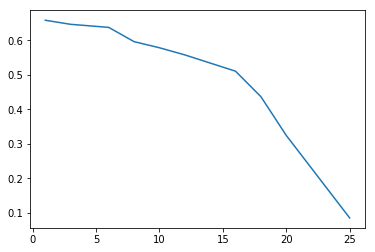

In [261]:
plt.plot(degs, accuracies2)

In [262]:
cms2

[array([[101,   2,   6,   1],
        [  2,   9,   5,  13],
        [ 15,   0,  51,  42],
        [  7,   0,  23,  62]], dtype=int64),
 array([[103,   1,   5,   1],
        [  2,   9,   8,  10],
        [ 16,   0,  52,  40],
        [  9,   0,  28,  55]], dtype=int64),
 array([[102,   0,   6,   2],
        [  8,   3,   2,  16],
        [ 18,   0,  53,  37],
        [ 10,   0,  24,  58]], dtype=int64),
 array([[98,  0,  7,  5],
        [11,  0,  2, 16],
        [21,  0, 49, 38],
        [15,  0, 22, 55]], dtype=int64),
 array([[96,  0,  8,  6],
        [14,  0,  1, 14],
        [21,  0, 46, 41],
        [19,  0, 19, 54]], dtype=int64),
 array([[96,  0,  8,  6],
        [15,  0,  1, 13],
        [27,  0, 42, 39],
        [26,  0, 15, 51]], dtype=int64),
 array([[106,   0,   4,   0],
        [ 24,   0,   0,   5],
        [ 47,   0,  38,  23],
        [ 52,   0,  11,  29]], dtype=int64),
 array([[109,   0,   1,   0],
        [ 27,   0,   1,   1],
        [ 72,   0,  25,  11],
        [ 72,

In [54]:
traindata_hog3, train_hogs3 = transf_hog(traindata, 8, 16, 16)
testdata_hog3, test_hogs3 = transf_hog(testdata, 8, 16, 16)

##benefits: huge dim reduc -> significant improve of efficiency + better accuracy

In [56]:
X_train, X_test, y_train, y_test = train_test_split(traindata_hog3, train_labels, random_state = 0, test_size = 0.3)

degs = [1, 3, 6, 8, 10, 12, 16, 18, 20, 25, 30, 40]
models = []
for deg in degs:
    svclassifier = SVC(kernel='poly', degree=deg, gamma='scale')
    curr_model = svclassifier.fit(X_train, y_train)
    models.append(curr_model)
    #print(deg)

In [57]:
accuracies3 = []
cms3 = []
for i in range(len(degs)):
    curr_predic = models[i].predict(X_test)
    curr_acc = models[i].score(X_test, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accuracies3.append(curr_acc)
    cms3.append(curr_cm)
    #print(i)

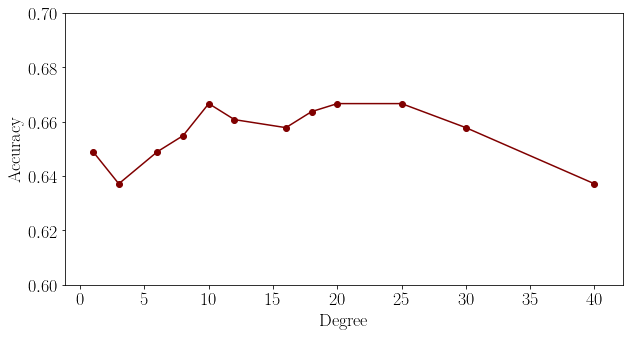

In [93]:
plt.plot(degs, accuracies3, 'maroon')
plt.scatter(degs, accuracies3, color='maroon')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.ylim(0.6, 0.7)
plt.savefig('Hog_acc70', dpi=200)

In [79]:
cms3

[array([[98,  4,  6,  2],
        [ 2, 10,  6, 11],
        [16,  0, 54, 38],
        [10,  1, 23, 58]], dtype=int64),
 array([[93,  2,  7,  8],
        [ 2, 14,  8,  5],
        [13,  0, 59, 36],
        [10,  1, 31, 50]], dtype=int64),
 array([[97,  2,  7,  4],
        [ 1, 15,  8,  5],
        [13,  0, 58, 37],
        [ 9,  1, 32, 50]], dtype=int64),
 array([[98,  2,  7,  3],
        [ 1, 16,  7,  5],
        [13,  0, 59, 36],
        [ 9,  1, 33, 49]], dtype=int64),
 array([[100,   2,   7,   1],
        [  0,  17,   7,   5],
        [ 13,   0,  59,  36],
        [  9,   1,  32,  50]], dtype=int64),
 array([[99,  3,  7,  1],
        [ 0, 18,  5,  6],
        [14,  0, 57, 37],
        [ 9,  1, 32, 50]], dtype=int64),
 array([[100,   3,   7,   0],
        [  0,  17,   6,   6],
        [ 15,   0,  58,  35],
        [ 11,   1,  32,  48]], dtype=int64),
 array([[101,   3,   6,   0],
        [  0,  17,   6,   6],
        [ 15,   0,  59,  34],
        [ 11,   1,  32,  48]], dtype=int64),


In [80]:
X_train, X_test, y_train, y_test = train_test_split(traindata_hog3, train_labels, random_state = 0, test_size = 0.1)

degs = [1, 3, 6, 8, 10, 12, 16, 18, 20, 25, 30, 40]
models = []
for deg in degs:
    svclassifier = SVC(kernel='poly', degree=deg, gamma='scale')
    curr_model = svclassifier.fit(X_train, y_train)
    models.append(curr_model)
    #print(deg)

In [81]:
accuracies4 = []
cms4 = []
for i in range(len(degs)):
    curr_predic = models[i].predict(X_test)
    curr_acc = models[i].score(X_test, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accuracies4.append(curr_acc)
    cms4.append(curr_cm)
    #print(i)

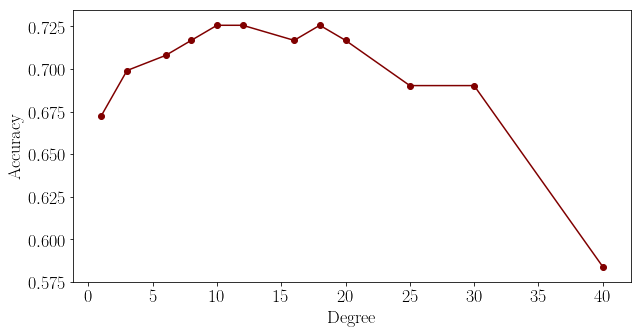

In [94]:
plt.plot(degs, accuracies4, 'maroon')
plt.scatter(degs, accuracies4, color='maroon')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.savefig('Hog_acc90', dpi=200)

In [109]:
splits = [0.2, 0.5, 0.7, 0.9]
accs_splits = []
cms_splits = []
for i in range(len(splits)):
    X_train, X_test, y_train, y_test = train_test_split(traindata_hog3, train_labels, random_state = 0, test_size = (1-splits[i]) )
    svclassifier = SVC(kernel='poly', degree=10, gamma='scale')
    curr_model = svclassifier.fit(X_train, y_train)
    
    curr_predic = curr_model.predict(X_test)
    curr_acc = curr_model.score(X_test, y_test)
    curr_cm = confusion_matrix(y_test, curr_predic)
    accs_splits.append(curr_acc)
    cms_splits.append(curr_cm)

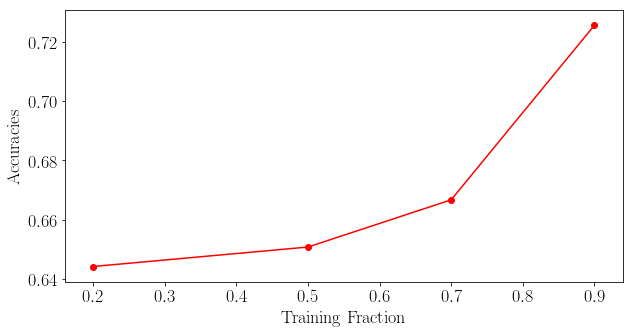

In [119]:
plt.plot(splits, accs_splits, 'red')
plt.scatter(splits, accs_splits, color='red')
plt.xlabel('Training Fraction')
plt.ylabel('Accuracies')
plt.savefig("Splits_acc", dpi=200)

## Submission

In [292]:
##Use hog with 16x16, kernel p=10
list_train_hog = list(traindata_hog3.values())
list_trainlabels = list(train_labels.values())

svclassifier = SVC(kernel='poly', degree=10, gamma='scale')
model = svclassifier.fit(list_train_hog, list_trainlabels) 

In [151]:
list_test_hog = list(testdata_hog3.values())

In [294]:
subm11 = model.predict(list_test_hog)

In [295]:
makesubmission(11, subm11)

In [149]:
##Use hog with 16x16, kernel p=10
list_train_hog = list(traindata_hog3.values())
list_trainlabels = list(train_labels.values())

svclassifier = SVC(kernel='poly', degree=20, gamma='scale')
model = svclassifier.fit(list_train_hog, list_trainlabels) 

In [152]:
subm13 = model.predict(list_test_hog)

In [153]:
makesubmission(13, subm13)

In [154]:
##Use hog with 16x16, kernel p=10
list_train_hog = list(traindata_hog3.values())
list_trainlabels = list(train_labels.values())

svclassifier = SVC(kernel='poly', degree=2, gamma='scale')
model = svclassifier.fit(list_train_hog, list_trainlabels) 

In [155]:
subm14 = model.predict(list_test_hog)

In [156]:
makesubmission(14, subm14)

### Kernelized Perceptron

In [305]:
perc_traindata_hog = add_bias(traindata_hog3)

In [307]:
train70, test30 = split(perc_traindata_hog, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

In [326]:
ps = [2, 4, 6, 10, 12, 15, 20, 25, 30]
iters =  [2000, 2500, 3000, 3500]

accs = np.zeros((len(ps), len(iters)))
all_alphas = {}

for i in range(len(ps)):
    for j in range(len(iters)):
        p = ps[i]
        it = iters[j]
        curr_alphas = kernel_perceptron(train70, trainlabels70, p, it)
        all_alphas[tuple((p, it))] = curr_alphas
        
        curr_res = kernel_predictall(train70, trainlabels70, curr_alphas, test30, p)
        curr_acc = uw_accuracy(curr_res, testlabels30)
        accs[i][j] = curr_acc
        
        #print(p, it)
        #print(curr_acc)
        #print()

In [327]:
#note: that performance across no. of iterations is most stable for p=10, 20 -> suggests that these are the natural spaces
#in which the data is best represented
best_accs = np.zeros(len(ps))
best_iters = np.zeros(len(ps))

for i in range(len(ps)):
    p = ps[i]
    best_accs[i] = np.max(accs[i])
    best_iters[i] = iters[np.argmax(accs[i])]

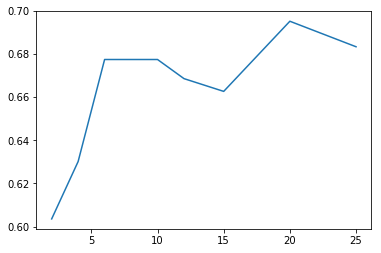

In [328]:
plt.plot(ps, best_accs)

In [329]:
#try with 10, 20
iterations = [1000, 1300, 1600, 1900, 2100, 2400, 2700, 3000, 3300, 3600, 4000, 4500, 5000]
accs_10 = []
accs_20 = []
for i in range(len(iterations)):
    alphas = kernel_perceptron(train70, trainlabels70, 10, iterations[i])
    res = kernel_predictall(train70, trainlabels70, alphas, test30, 10)
    accs_10.append(uw_accuracy(res, testlabels30))
    
    alphas = kernel_perceptron(train70, trainlabels70, 20, iterations[i])
    res = kernel_predictall(train70, trainlabels70, alphas, test30, 20)
    accs_20.append(uw_accuracy(res, testlabels30))
    
    #print(i)
## 10, 1200 ->0.674

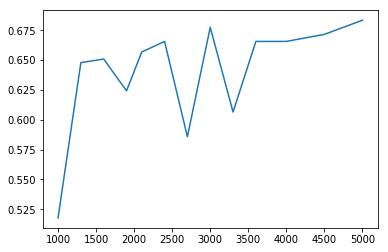

In [330]:
plt.plot(iterations, accs_10)

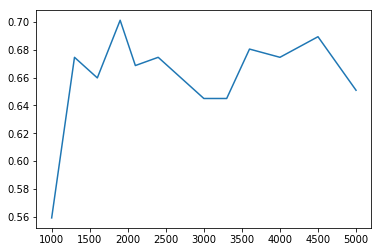

In [331]:
plt.plot(iterations, accs_20)

In [332]:
train90, test10 = split(perc_traindata_hog, 0.9)
trainlabels90, testlabels10 = split(train_labels, 0.9)

In [334]:
alphas = kernel_perceptron(train90, trainlabels90, 20, 4500)
res = kernel_predictall(train90, trainlabels90, alphas, test10, 20)
uw_accuracy(res, testlabels10)

0.6428571428571429

In [335]:
#try with 10, 20
iterations = [1000, 1300, 1600, 1900, 2100, 2400, 2700, 3000, 3300, 3600, 4000, 4500, 5000]
accs90_10 = []
accs90_20 = []
for i in range(len(iterations)):
    alphas = kernel_perceptron(train90, trainlabels90, 10, iterations[i])
    res = kernel_predictall(train90, trainlabels90, alphas, test10, 10)
    accs90_10.append(uw_accuracy(res, testlabels10))
    
    alphas = kernel_perceptron(train90, trainlabels90, 20, iterations[i])
    res = kernel_predictall(train90, trainlabels90, alphas, test10, 20)
    accs90_20.append(uw_accuracy(res, testlabels10))
    
    #print(i)
## 10, 1200 ->0.674

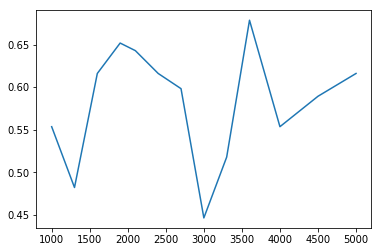

In [336]:
plt.plot(iterations, accs90_10)

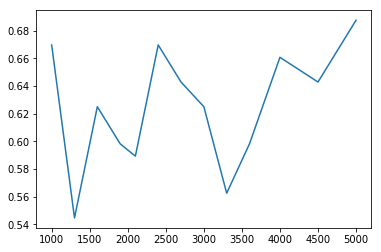

In [337]:
plt.plot(iterations, accs90_20)

### Make submission

In [340]:
perc_testdata_hog = add_bias(testdata_hog3)

In [342]:
alphas = kernel_perceptron(train70, trainlabels70, 10, 5000)

In [343]:
subm12 = kernel_predictall(train70, trainlabels70, alphas, perc_testdata_hog, 10)

In [344]:
makesubmission(12, subm12)

## Report Analysis

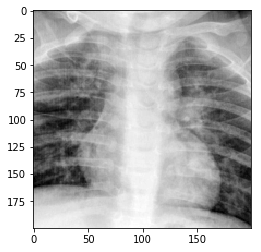

In [354]:
fig, ax = plt.subplots(1,1)
ax.imshow(traindata[1], cmap='gray')
fig.savefig('Read1')

In [356]:
raw_traindata[1].shape

(498, 918)

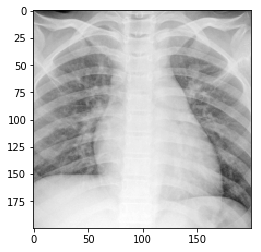

In [357]:
fig, ax = plt.subplots(1,1)
ax.imshow(traindata[12], cmap='gray')
#fig.savefig('Read1')

In [370]:
train70, test30 = split(perc_traindata, 0.7)
trainlabels70, testlabels30 = split(train_labels, 0.7)

In [384]:
iters = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
perc_accs = []
for i in range(len(iters)):
    it = iters[i]
    weights = uw_perceptron(train70, trainlabels70, it)
    res = predictall(weights, test30)
    perc_accs.append(uw_accuracy(res, testlabels30))

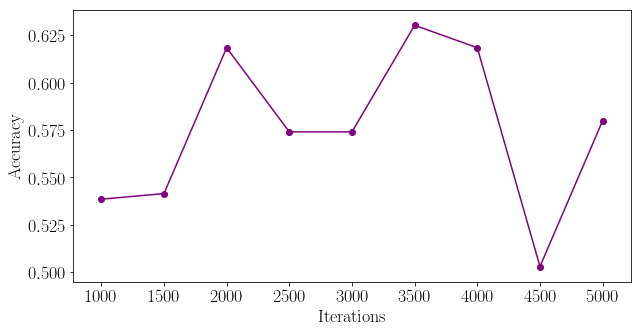

In [385]:
plt.plot(iters, perc_accs, color = 'purple', label = 'Linear Perceptron')
plt.scatter(iters, perc_accs, color = 'purple', label = 'Linear Perceptron')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.savefig('Perc_Acc', dpi = 200)

In [419]:
weights = uw_perceptron(train70, trainlabels70, 3500)
res = predictall(weights, test30)

In [420]:
labs = np.zeros(4)
for key in res:
    labs[res[key]] += 1
    
true_labs = np.zeros(4)
for key in res:
    true_labs[testlabels30[key]] += 1

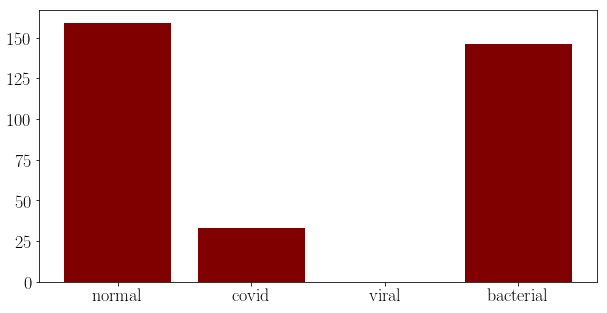

In [421]:
plt.bar(['normal', 'covid', 'viral', 'bacterial'], labs, color='maroon')
plt.savefig('perc_labs', dpi=200)

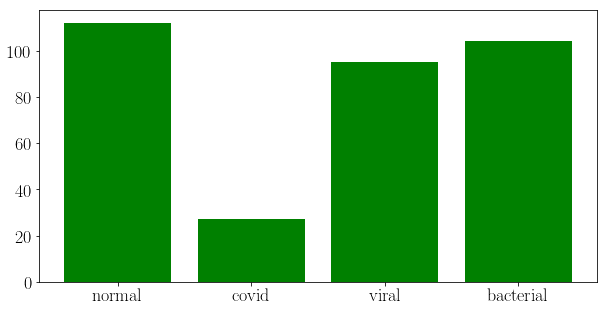

In [414]:
plt.bar(['normal', 'covid', 'viral', 'bacterial'], true_labs, color='green')
plt.savefig('true_labs', dpi=200)

In [422]:
weights = uw_perceptron(train70, trainlabels70, 5000)
res = predictall(weights, test30)

In [423]:
labs = np.zeros(4)
for key in res:
    labs[res[key]] += 1
    
true_labs = np.zeros(4)
for key in res:
    true_labs[testlabels30[key]] += 1

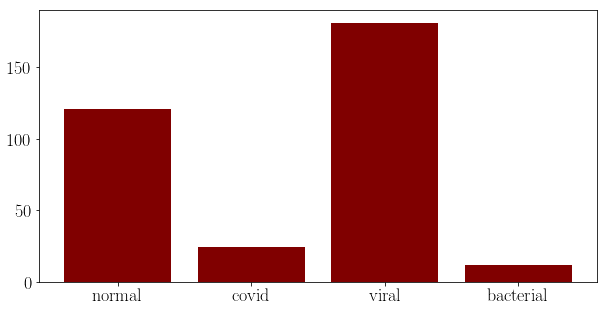

In [424]:
plt.bar(['normal', 'covid', 'viral', 'bacterial'], labs, color='maroon')
plt.savefig('perc_labs2', dpi=200)

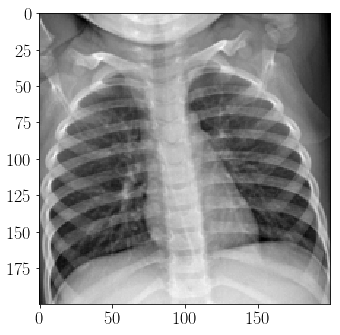

In [72]:
plt.imshow(traindata[0], cmap='gray')
plt.tight_layout()
plt.savefig('Img0.pdf', dpi=200)

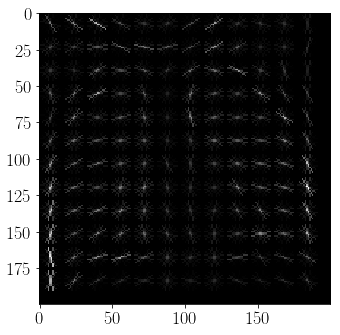

In [73]:
plt.imshow(train_hogs3[0], cmap='gray')
plt.tight_layout()
plt.savefig('Img0_hog.pdf', dpi=200)

#### Error Analysis

In [120]:
 X_train, X_test, y_train, y_test = train_test_split(traindata_hog3, train_labels, random_state = 0, test_size = 0.3)
svclassifier = SVC(kernel='poly', degree=10, gamma='scale')
model = svclassifier.fit(X_train, y_train)

In [143]:
predic = model.predict(X_test)
acc = accuracy_score(y_test, predic)
cm = confusion_matrix(y_test, predic)
prec = precision_score(y_test, predic, average = 'macro')
recall = recall_score(y_test, predic, average = 'macro')
f1 = f1_score(y_test, predic, average = 'macro')

In [137]:
cm

array([[100,   2,   7,   1],
       [  0,  17,   7,   5],
       [ 13,   0,  59,  36],
       [  9,   1,  32,  50]], dtype=int64)

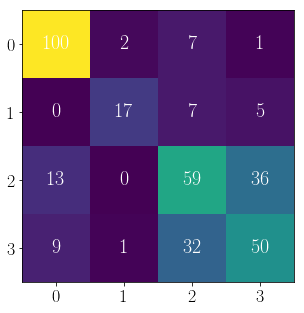

In [157]:
plt.imshow(cm)
for i in range(4):
        for j in range(4):
            plt.text(j, i, '%d' %cm[i][j], horizontalalignment='center', verticalalignment='center', color='white',
                           fontsize = 20)
            
plt.savefig('CM', dpi=200)

In [162]:
acc, prec, recall, f1

(0.6666666666666666, 0.693763788480467, 0.6462680907021237, 0.6633538469339633)